## Interpretation of Transfer Learning model
### Pre-training: MLM using TransformerEncoder
Dataset: UniRef90 Viridae Sequences

### Fine-tuning: Pretrained TransformerEncoder + FFN-2L
Datasets:
- UniProtKB: coronaviridae

### Attention Analysis
Wuhan Index Spike protein sequence: WIV04

In [1]:
import sys
import os

sys.path.append(os.path.join(os.getcwd(), "..", "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", ".."))
sys.path.append(os.path.join(os.getcwd(), ".."))
sys.path

['/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/gradient_based_interpretation/uniref90',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python310.zip',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/lib-dynload',
 '',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/site-packages',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/site-packages/PyQt5_sip-12.11.0-py3.10-linux-x86_64.egg',
 '/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/gradient_based_interpretation/uniref90/../../../..',
 '/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/gradient_based_interpretation/uniref90/../../..',
 '/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/gradient_based_interpretation/uniref90/../..',
 '/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/gradient_based_interpretation/uniref90/..']

In [2]:
from models.nlp.transformer import transformer
from src.utils import utils, nn_utils, dataset_utils, visualization_utils
from src.training import pre_training_masked_language_modeling
from src.training.fine_tuning import host_prediction

import torch
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.manifold import TSNE



In [3]:
input_dir = "/home/grads/blessyantony/dev/git/zoonosis/input/data/uniref90/splits/s79221635"
train_file_names = ["uniref90_final.csv_tr0.8_train.csv"]
test_file_names = ["uniref90_final.csv_tr0.8_test.csv"]

label_groupings = {"Human": [ "Homo sapiens" ],
                  "Desert warthog": [ "Phacochoerus aethiopicus" ],
                  "Lesser bandicoot rat": [ "Bandicota bengalensis" ],
                  "Horse": [ "Equus caballus" ],
                  "Goat": [ "Capra hircus" ],
                  "Red junglefowl": [ "Gallus gallus" ],
                  "Wood mouse": [ "Apodemus sylvaticus" ],
                  "Cattle": [ "Bos taurus" ],
                  "Others": [ "*" ]}
host_classes = ["Homo sapiens",  "Phacochoerus aethiopicus",    "Bandicota bengalensis",     "Equus caballus",   "Capra hircus", 
                "Gallus gallus",   "Apodemus sylvaticus",     "Bos taurus",  "Others"]

amino_acid_idx_map = {'A': 1, 'R': 2, 'N': 3, 'D': 4, 'C': 5,
                  'Q': 6, 'E': 7, 'G': 8, 'H': 9, 'I': 10,
                  'L': 11, 'K': 12, 'M': 13, 'F': 14, 'P': 15,
                  'O': 16, 'S': 17, 'U': 18, 'T': 19, 'W': 20,
                  'Y': 21, 'V': 22, 'B': 23, 'Z': 24, 'X': 25,
                  'J': 26}
idx_amino_acid_map = {v:k for k,v in amino_acid_idx_map.items()}

train_sequence_settings =  {
    "sequence_col": "seq",
    "batch_size": 8,
    "max_sequence_length": 1366,
    "pad_sequence_val": 0,
    "truncate": True,
    "feature_type": "token",
    "pad_token_val": 0
}

test_sequence_settings =  train_sequence_settings.copy()
test_sequence_settings["batch_size"] = 1

label_settings = {
    "label_col": "virus_host_name",
    "exclude_labels": [ "nan"],
    "label_groupings":  label_groupings
}

encoder_settings = {
    "n_heads": 8,
    "depth": 6,
    "input_dim": 512, # input embedding dimension
    "hidden_dim": 1024,
    "n_tokens": 28,
    "max_seq_len": 1366
}


mlm_settings = {
    "no_mask_token_vals": [ 0 ],
    "n_tokens": 26,
    "mask_prob": 0.15,
    "random_mask_prob": 0.1,
    "no_change_mask_prob": 0.1,
    "encoder_dim": 512,
    "pad_token_val": 0
}

fine_tune_settings = {
    "depth": 2,
    "n_classes": 9,
    "input_dim": 512, # input embedding dimension
    "hidden_dim": 1024
}

figure_config = {
    "figsize": (10, 10),
    "xtick.labelsize": 18,
    "ytick.labelsize": 18    
}

### Training-based interpretation
#### Encoding visualization - all viruses, all hosts

In [4]:
def compute_dataset_representations_pretrained_model(model, dataset_loader):
    model.eval()
    seq_dfs = []
    for _, record in enumerate(dataset_loader):
        seq, label = record
        output = model(seq, mask=None)
        seq_encoding = model.encoder.encoding
        # embedding = value for each dimension = mean of the dimensional values of all tokens in the input sequence
        seq_encoding = torch.mean(seq_encoding, dim=1, keepdim=True)
        seq_df = pd.DataFrame(seq_encoding.squeeze().cpu().detach().numpy())
        seq_df["label"] = label.squeeze().cpu().detach().numpy()
        seq_dfs.append(seq_df)
    df = pd.concat(seq_dfs)
    print(df.shape)
    return df


def compute_dataset_representations_finetuned_model(model, dataset_loader):
    model.eval()
    seq_dfs = []
    for _, record in enumerate(dataset_loader):
        seq, label = record
        output = model(seq)
        # embedding = value for each dimension = mean of the dimensional values of all tokens in the input sequence
        seq_encoding = model.fine_tuned_embedding
        seq_df = pd.DataFrame(seq_encoding.squeeze().cpu().detach().numpy())
        seq_df["label"] = label.squeeze().cpu().detach().numpy()
        seq_dfs.append(seq_df)
    df = pd.concat(seq_dfs)
    print(df.shape)
    return df

def visualize_dataset(rep_df):
    columns = rep_df.columns
    print(columns)
    X = rep_df[range(512)]
    tsne_model = TSNE(n_components=2, verbose=1, init="pca", learning_rate="auto").fit(X)
    X_emb = pd.DataFrame(tsne_model.fit_transform(X))
    print(X_emb.shape)
    print(X_emb)
    X_emb["label"] = rep_df["label"].values
    X_emb["label"] = X_emb["label"].map(index_label_map)
    X_emb = X_emb[X_emb["label"] != "Others"]
    # TODO: remove this harcoded order. 
    # This order is based on the TSNE visualization for the embeddings of TransformerEncoder model w/o transfer learning
    hue_order = ["Human", "Horse", "Cattle", "Lesser bandicoot rat", "Goat", "Desert warthog", "Red junglefowl", "Wood mouse"]
    sns.scatterplot(data = X_emb, x=0, y=1, hue="label", hue_order=hue_order)
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    plt.show()
    return tsne_model, X_emb
    

### Testing-based interpretation
#### Attention based interpretation

In [10]:
def compute_mean_attn_values(tf_model):
    attn_values = tf_model.encoder.layers[5].self_attn.self_attn.squeeze()
    return torch.mean(attn_values, dim=0)


def plot_mean_attention_values(x, seq=None, seq_len=None):
    ticklabels = seq.cpu().detach().numpy().squeeze()[:seq_len]
    ticklabels_mapped = [idx_amino_acid_map[x] for x in ticklabels]
    data = x.cpu().detach().numpy()
    
    figure_config["xtick.labelsize"] = 5
    figure_config["ytick.labelsize"] = 5
    figure_config["figsize"] = (12,12)
    
    visualization_utils.pre_plot_config(figure_config)
    
    sns.heatmap(data=data[:seq_len, :seq_len], xticklabels=ticklabels_mapped, yticklabels=ticklabels_mapped)
    plt.show()


def plot_mean_of_mean_attention_values(x, seq=None, seq_len=None, seq_max_length=None):
    tokens = seq.cpu().detach().numpy().squeeze()
    
    x = torch.mean(x, dim=0)
    df = pd.DataFrame({"tokens": tokens, "attn_vals": x.cpu().detach().numpy(), "pos": range(seq_max_length)})
    df["tokens"] = df["tokens"].map(idx_amino_acid_map)
    df = df.dropna()
    sorted_df = df.sort_values(by="attn_vals", ascending=False).head(10)
    print("Top 10 tokens + positions with highest attention values for the whole sequence")
    print(sorted_df.head(10))
    
    figure_config["xtick.labelsize"] = 8
    figure_config["ytick.labelsize"] = 8
    figure_config["figsize"] = (12,6)
    visualization_utils.pre_plot_config(figure_config)
    sns.scatterplot(data=df, x="pos", y="attn_vals", hue="tokens")
    plt.show()
    
    
def analyze_attention_of_sequence(tf_model, sample_seq, sample_label, seq_max_length):
    # sample_seq = sample_seq.unsqueeze(0)
    seq_len= torch.count_nonzero(sample_seq)
    print(sample_seq.shape)
    print(f"seq_len = {seq_len}")
    
    tf_model.eval()
    _ = tf_model(sample_seq, mask=None)
    mean_attn_values = compute_mean_attn_values(tf_model)

    plot_mean_attention_values(mean_attn_values, seq=sample_seq, seq_len=seq_len)
    plot_mean_of_mean_attention_values(mean_attn_values, seq=sample_seq, seq_len=seq_len, seq_max_length=seq_max_length)
    
def analyze_attention_of_prediction(fine_tuned_model, sample_seq, sample_label, seq_max_length):
    # sample_seq = sample_seq.unsqueeze(0)
    seq_len= torch.count_nonzero(sample_seq)
    print(sample_seq.shape)
    print(f"seq_len = {seq_len}")
    
    fine_tuned_model.eval()
    output = fine_tuned_model(sample_seq)
    sample_pred = torch.argmax(F.softmax(output, dim=1), dim=1)
    print(f"Label = {index_label_map[sample_label.item()]}")
    print(f"Prediction = {index_label_map[sample_pred.item()]}")
    mean_attn_values = compute_mean_attn_values(fine_tuned_model.pre_trained_model)

    plot_mean_attention_values(mean_attn_values, seq=sample_seq, seq_len=seq_len)
    plot_mean_of_mean_attention_values(mean_attn_values, seq=sample_seq, seq_len=seq_len, seq_max_length=seq_max_length)

### Load the datasets

#### UniRef90 Datasets
all viruses, mammals+aves, all hosts, all proteins, without duplicates and single hosts (19K)

In [11]:
index_label_map, train_dataset_loader = dataset_utils.load_dataset(input_dir=input_dir,
                                                                   input_file_names=train_file_names,
                                                                   sequence_settings=train_sequence_settings,
                                                                   cols=[train_sequence_settings["sequence_col"], label_settings["label_col"]],
                                                                   label_settings=label_settings,
                                                                   label_col=label_settings["label_col"],
                                                                   classification_type="multi")

index_label_map, test_dataset_loader = dataset_utils.load_dataset(input_dir=input_dir,
                                                                   input_file_names=test_file_names,
                                                                   sequence_settings=test_sequence_settings,
                                                                   cols=[test_sequence_settings["sequence_col"], label_settings["label_col"]],
                                                                   label_settings=label_settings,
                                                                   label_col=label_settings["label_col"],
                                                                   classification_type="multi")
# Random seq, label from test_dataset_loader
test_seq, test_label = next(iter(test_dataset_loader))

input file: /home/grads/blessyantony/dev/git/zoonosis/input/data/uniref90/splits/s79221635/uniref90_final.csv_tr0.8_train.csv, size = (15274, 2)
Size of input dataset = (15274, 2)
Grouping labels using config : {'Human': ['Homo sapiens'], 'Desert warthog': ['Phacochoerus aethiopicus'], 'Lesser bandicoot rat': ['Bandicota bengalensis'], 'Horse': ['Equus caballus'], 'Goat': ['Capra hircus'], 'Red junglefowl': ['Gallus gallus'], 'Wood mouse': ['Apodemus sylvaticus'], 'Cattle': ['Bos taurus'], 'Others': ['*']}
label_idx_map={'Cattle': 0, 'Desert warthog': 1, 'Goat': 2, 'Horse': 3, 'Human': 4, 'Lesser bandicoot rat': 5, 'Others': 6, 'Red junglefowl': 7, 'Wood mouse': 8}
idx_label_map={0: 'Cattle', 1: 'Desert warthog', 2: 'Goat', 3: 'Horse', 4: 'Human', 5: 'Lesser bandicoot rat', 6: 'Others', 7: 'Red junglefowl', 8: 'Wood mouse'}


input file: /home/grads/blessyantony/dev/git/zoonosis/input/data/uniref90/splits/s79221635/uniref90_final.csv_tr0.8_test.csv, size = (3819, 2)
Size of input dataset = (3819, 2)
Grouping labels using config : {'Human': ['Homo sapiens'], 'Desert warthog': ['Phacochoerus aethiopicus'], 'Lesser bandicoot rat': ['Bandicota bengalensis'], 'Horse': ['Equus caballus'], 'Goat': ['Capra hircus'], 'Red junglefowl': ['Gallus gallus'], 'Wood mouse': ['Apodemus sylvaticus'], 'Cattle': ['Bos taurus'], 'Others': ['*']}
label_idx_map={'Cattle': 0, 'Desert warthog': 1, 'Goat': 2, 'Horse': 3, 'Human': 4, 'Lesser bandicoot rat': 5, 'Others': 6, 'Red junglefowl': 7, 'Wood mouse': 8}
idx_label_map={0: 'Cattle', 1: 'Desert warthog', 2: 'Goat', 3: 'Horse', 4: 'Human', 5: 'Lesser bandicoot rat', 6: 'Others', 7: 'Red junglefowl', 8: 'Wood mouse'}


#### WIV04 Wuhan Index Virus S protein

In [13]:
wiv04_df = pd.read_csv("/home/grads/blessyantony/dev/git/zoonosis/input/data/coronaviridae/sarscov2/sarscov2-S-WIV04ref.csv")
wiv04_df.rename(columns={"virus_host": "virus_host_name"}, inplace=True)
wiv04_df["virus_host_name"] = "Human"
wiv04_df.head()

,id,seq,virus,seq_len,virus_host_name,binary_label
0,WIV04,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,WIV04(MN996528.1) Wuhan variant index virus,1273,Human,Human


In [14]:
_, wiv04_dataset_loader = dataset_utils.load_dataset_with_df(df=wiv04_df,
                                                             sequence_settings=test_sequence_settings,
                                                             label_settings=label_settings,
                                                             label_col="virus_host_name",
                                                             classification_type="multi")
wiv04_seq, wiv04_label = next(iter(wiv04_dataset_loader))
print(wiv04_seq)
print(wiv04_label)

Grouping labels using config : {'Human': ['Homo sapiens'], 'Desert warthog': ['Phacochoerus aethiopicus'], 'Lesser bandicoot rat': ['Bandicota bengalensis'], 'Horse': ['Equus caballus'], 'Goat': ['Capra hircus'], 'Red junglefowl': ['Gallus gallus'], 'Wood mouse': ['Apodemus sylvaticus'], 'Cattle': ['Bos taurus'], 'Others': ['*']}
label_idx_map={'Cattle': 0, 'Desert warthog': 1, 'Goat': 2, 'Horse': 3, 'Human': 4, 'Lesser bandicoot rat': 5, 'Others': 6, 'Red junglefowl': 7, 'Wood mouse': 8}
idx_label_map={0: 'Cattle', 1: 'Desert warthog', 2: 'Goat', 3: 'Horse', 4: 'Human', 5: 'Lesser bandicoot rat', 6: 'Others', 7: 'Red junglefowl', 8: 'Wood mouse'}
tensor([[13., 14., 22.,  ...,  0.,  0.,  0.]], device='cuda:0',
       dtype=torch.float64)
tensor([4], device='cuda:0')


### Load the trained model

#### Models
##### Pre-trained model: TransformerEncoder (MLM)
##### Training Dataset: UniRef90 Viridae

In [16]:
mlm_model_path = "/home/grads/blessyantony/dev/git/zoonosis/output/raw/uniref90/20231115/pre_training/mlm/transformer_encoder-l_6-h_8-lr1e-4-mlm_itr0.pth"
pre_trained_transformer_encoder_model = transformer.get_transformer_encoder(encoder_settings)
pre_trained_transformer_encoder_model.load_state_dict(torch.load(mlm_model_path))
pre_trained_transformer_encoder_model = pre_trained_transformer_encoder_model.to(nn_utils.get_device())

TransformerEncoder(
  (embedding): EmbeddingLayer(
    (token_embedding): Embedding(28, 512)
    (positional_embedding): PositionalEncoding()
  )
  (encoder): Encoder(
    (layers): ModuleList(
      (0-5): 6 x EncoderLayer(
        (self_attn): MultiHeadAttention(
          (W_Q): Linear(in_features=512, out_features=512, bias=True)
          (W_K): Linear(in_features=512, out_features=512, bias=True)
          (W_V): Linear(in_features=512, out_features=512, bias=True)
          (W_O): Linear(in_features=512, out_features=512, bias=True)
        )
        (feed_forward): FeedForwardLayer(
          (W_1): Linear(in_features=512, out_features=1024, bias=True)
          (W_2): Linear(in_features=1024, out_features=512, bias=True)
        )
        (residual_connections): ModuleList(
          (0-1): 2 x ResidualConnectionLayer(
            (norm): NormalizationLayer()
          )
        )
      )
    )
    (norm): NormalizationLayer()
  )
)
Number of parameters =  12618752


##### Fine-Tuned model: Pre-trained TransformerEncoder + FFN-2L (Host Prediction)
##### Training Dataset: UniRef90 - all viruses, mammals+aves, all hosts, all proteins, without duplicates and single hosts (19K)

In [17]:
host_prediction_model_path = "/home/grads/blessyantony/dev/git/zoonosis/output/raw/uniref90/20231115/fine_tuning/host_prediction/host_prediction_fnn_2l_lr1e-4_itr0.pth"
fine_tune_settings["pre_trained_model"] = pre_trained_transformer_encoder_model
fine_tuned_host_prediction_model_uniref90 = host_prediction.get_host_prediction_model(fine_tune_settings)
fine_tuned_host_prediction_model_uniref90.load_state_dict(torch.load(host_prediction_model_path))


HostPrediction(
  (pre_trained_model): TransformerEncoder(
    (embedding): EmbeddingLayer(
      (token_embedding): Embedding(28, 512)
      (positional_embedding): PositionalEncoding()
    )
    (encoder): Encoder(
      (layers): ModuleList(
        (0-5): 6 x EncoderLayer(
          (self_attn): MultiHeadAttention(
            (W_Q): Linear(in_features=512, out_features=512, bias=True)
            (W_K): Linear(in_features=512, out_features=512, bias=True)
            (W_V): Linear(in_features=512, out_features=512, bias=True)
            (W_O): Linear(in_features=512, out_features=512, bias=True)
          )
          (feed_forward): FeedForwardLayer(
            (W_1): Linear(in_features=512, out_features=1024, bias=True)
            (W_2): Linear(in_features=1024, out_features=512, bias=True)
          )
          (residual_connections): ModuleList(
            (0-1): 2 x ResidualConnectionLayer(
              (norm): NormalizationLayer()
            )
          )
        )
    

<All keys matched successfully>

##### Fine-Tuned model: Pre-trained TransformerEncoder + FFN-2L (Host Prediction)
##### Training Dataset: UniProtKB: Coronaviridae

In [18]:
host_prediction_model_path = "/home/grads/blessyantony/dev/git/zoonosis/output/raw/coronaviridae/20231127/fine_tuning/host_prediction/host_prediction_fnn_2l_lr1e-5_itr0.pth"
fine_tune_settings["pre_trained_model"] = pre_trained_transformer_encoder_model
fine_tune_settings["n_classes"] = 7
fine_tuned_host_prediction_model_coronaviridae = host_prediction.get_host_prediction_model(fine_tune_settings)
fine_tuned_host_prediction_model_coronaviridae.load_state_dict(torch.load(host_prediction_model_path))


HostPrediction(
  (pre_trained_model): TransformerEncoder(
    (embedding): EmbeddingLayer(
      (token_embedding): Embedding(28, 512)
      (positional_embedding): PositionalEncoding()
    )
    (encoder): Encoder(
      (layers): ModuleList(
        (0-5): 6 x EncoderLayer(
          (self_attn): MultiHeadAttention(
            (W_Q): Linear(in_features=512, out_features=512, bias=True)
            (W_K): Linear(in_features=512, out_features=512, bias=True)
            (W_V): Linear(in_features=512, out_features=512, bias=True)
            (W_O): Linear(in_features=512, out_features=512, bias=True)
          )
          (feed_forward): FeedForwardLayer(
            (W_1): Linear(in_features=512, out_features=1024, bias=True)
            (W_2): Linear(in_features=1024, out_features=512, bias=True)
          )
          (residual_connections): ModuleList(
            (0-1): 2 x ResidualConnectionLayer(
              (norm): NormalizationLayer()
            )
          )
        )
    

<All keys matched successfully>

##### Pre-trained Model: TransformerEncoder

(15274, 513)
Index([      0,       1,       2,       3,       4,       5,       6,       7,
             8,       9,
       ...
           503,     504,     505,     506,     507,     508,     509,     510,
           511, 'label'],
      dtype='object', length=513)
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 15274 samples in 0.007s...
[t-SNE] Computed neighbors for 15274 samples in 8.484s...
[t-SNE] Computed conditional probabilities for sample 1000 / 15274
[t-SNE] Computed conditional probabilities for sample 2000 / 15274
[t-SNE] Computed conditional probabilities for sample 3000 / 15274
[t-SNE] Computed conditional probabilities for sample 4000 / 15274
[t-SNE] Computed conditional probabilities for sample 5000 / 15274
[t-SNE] Computed conditional probabilities for sample 6000 / 15274
[t-SNE] Computed conditional probabilities for sample 7000 / 15274
[t-SNE] Computed conditional probabilities for sample 8000 / 15274
[t-SNE] Computed conditional probabilities for sample 

/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.536400
[t-SNE] KL divergence after 1000 iterations: 1.024119
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 15274 samples in 0.009s...
[t-SNE] Computed neighbors for 15274 samples in 8.754s...
[t-SNE] Computed conditional probabilities for sample 1000 / 15274
[t-SNE] Computed conditional probabilities for sample 2000 / 15274
[t-SNE] Computed conditional probabilities for sample 3000 / 15274
[t-SNE] Computed conditional probabilities for sample 4000 / 15274
[t-SNE] Computed conditional probabilities for sample 5000 / 15274
[t-SNE] Computed conditional probabilities for sample 6000 / 15274
[t-SNE] Computed conditional probabilities for sample 7000 / 15274
[t-SNE] Computed conditional probabilities for sample 8000 / 15274
[t-SNE] Computed conditional probabilities for sample 9000 / 15274
[t-SNE] Computed conditional probabilities for sample 10000 / 15274
[t-SNE] Computed conditional probabilities for sample 

/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.538902
[t-SNE] KL divergence after 1000 iterations: 1.024465
(15274, 2)
               0          1
0     -23.088184 -39.006260
1     -30.429958 -34.174294
2      65.855156  29.623224
3      43.976097  48.183697
4     -37.016460  93.431725
...          ...        ...
15269 -38.880379  17.557882
15270  65.017433  -0.002239
15271  60.726761 -56.597958
15272 -66.609474  -3.450917
15273 -27.424986  75.103683

[15274 rows x 2 columns]


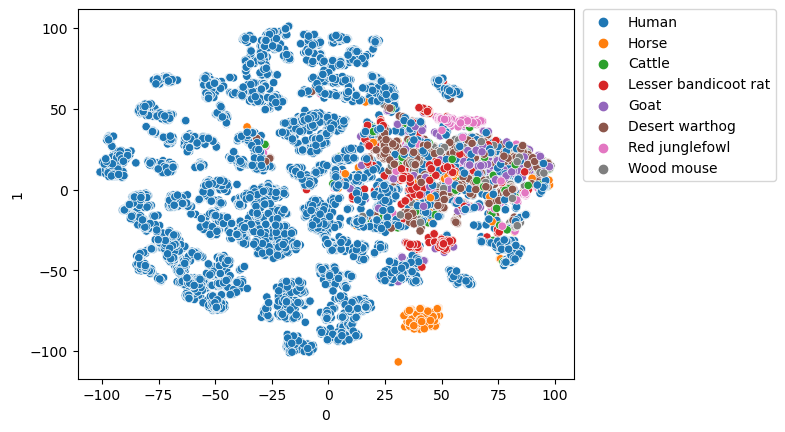

(TSNE(init='pca', learning_rate='auto', verbose=1),
                0          1                 label
 0     -23.088184 -39.006260                 Human
 1     -30.429958 -34.174294                 Human
 2      65.855156  29.623224        Desert warthog
 3      43.976097  48.183697  Lesser bandicoot rat
 4     -37.016460  93.431725                 Human
 ...          ...        ...                   ...
 15269 -38.880379  17.557882                 Human
 15270  65.017433  -0.002239        Desert warthog
 15271  60.726761 -56.597958                 Human
 15272 -66.609474  -3.450917                 Human
 15273 -27.424986  75.103683                 Human
 
 [14662 rows x 3 columns])

In [19]:
train_rep_df = compute_dataset_representations_pretrained_model(pre_trained_transformer_encoder_model, train_dataset_loader)
visualize_dataset(train_rep_df)

##### Fine-tuned Model: TransformerEncoder for Host prediction
###### fine_tuned_host_prediction_model_uniref90

(15274, 1025)
Index([      0,       1,       2,       3,       4,       5,       6,       7,
             8,       9,
       ...
          1015,    1016,    1017,    1018,    1019,    1020,    1021,    1022,
          1023, 'label'],
      dtype='object', length=1025)
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 15274 samples in 0.006s...
[t-SNE] Computed neighbors for 15274 samples in 8.432s...
[t-SNE] Computed conditional probabilities for sample 1000 / 15274
[t-SNE] Computed conditional probabilities for sample 2000 / 15274
[t-SNE] Computed conditional probabilities for sample 3000 / 15274
[t-SNE] Computed conditional probabilities for sample 4000 / 15274
[t-SNE] Computed conditional probabilities for sample 5000 / 15274
[t-SNE] Computed conditional probabilities for sample 6000 / 15274
[t-SNE] Computed conditional probabilities for sample 7000 / 15274
[t-SNE] Computed conditional probabilities for sample 8000 / 15274
[t-SNE] Computed conditional probabilities for sampl

/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.295746
[t-SNE] KL divergence after 1000 iterations: 1.157241
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 15274 samples in 0.012s...
[t-SNE] Computed neighbors for 15274 samples in 8.598s...
[t-SNE] Computed conditional probabilities for sample 1000 / 15274
[t-SNE] Computed conditional probabilities for sample 2000 / 15274
[t-SNE] Computed conditional probabilities for sample 3000 / 15274
[t-SNE] Computed conditional probabilities for sample 4000 / 15274
[t-SNE] Computed conditional probabilities for sample 5000 / 15274
[t-SNE] Computed conditional probabilities for sample 6000 / 15274
[t-SNE] Computed conditional probabilities for sample 7000 / 15274
[t-SNE] Computed conditional probabilities for sample 8000 / 15274
[t-SNE] Computed conditional probabilities for sample 9000 / 15274
[t-SNE] Computed conditional probabilities for sample 10000 / 15274
[t-SNE] Computed conditional probabilities for sample 

/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.295761
[t-SNE] KL divergence after 1000 iterations: 1.157936
(15274, 2)
               0          1
0     -39.481594  59.672489
1     -12.891350 -83.252388
2      39.757324  44.705456
3     -28.482752  51.362278
4      90.481171  -3.026405
...          ...        ...
15269 -81.690613 -73.794212
15270 -38.014542  18.977959
15271   3.045211 -25.198990
15272  -9.725394 -30.612249
15273   0.831693 -55.413338

[15274 rows x 2 columns]


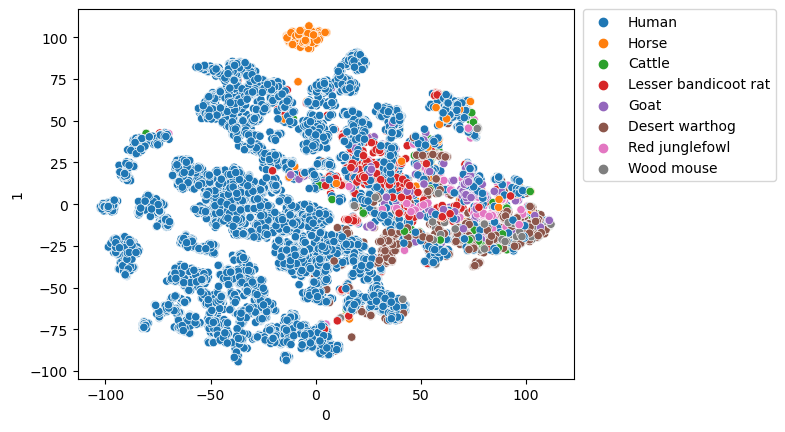

(TSNE(init='pca', learning_rate='auto', verbose=1),
                0          1  label
 0     -39.481594  59.672489  Human
 1     -12.891350 -83.252388  Human
 2      39.757324  44.705456  Human
 3     -28.482752  51.362278  Human
 4      90.481171  -3.026405  Human
 ...          ...        ...    ...
 15269 -81.690613 -73.794212  Human
 15270 -38.014542  18.977959  Human
 15271   3.045211 -25.198990  Human
 15272  -9.725394 -30.612249  Human
 15273   0.831693 -55.413338  Human
 
 [14662 rows x 3 columns])

In [20]:
train_rep_df = compute_dataset_representations_finetuned_model(fine_tuned_host_prediction_model_uniref90, train_dataset_loader)
visualize_dataset(train_rep_df)

### Attention values analysis for WIV04 sequence

##### Pretrained Transformer Encoder Model

torch.Size([1, 1366])
seq_len = 1273


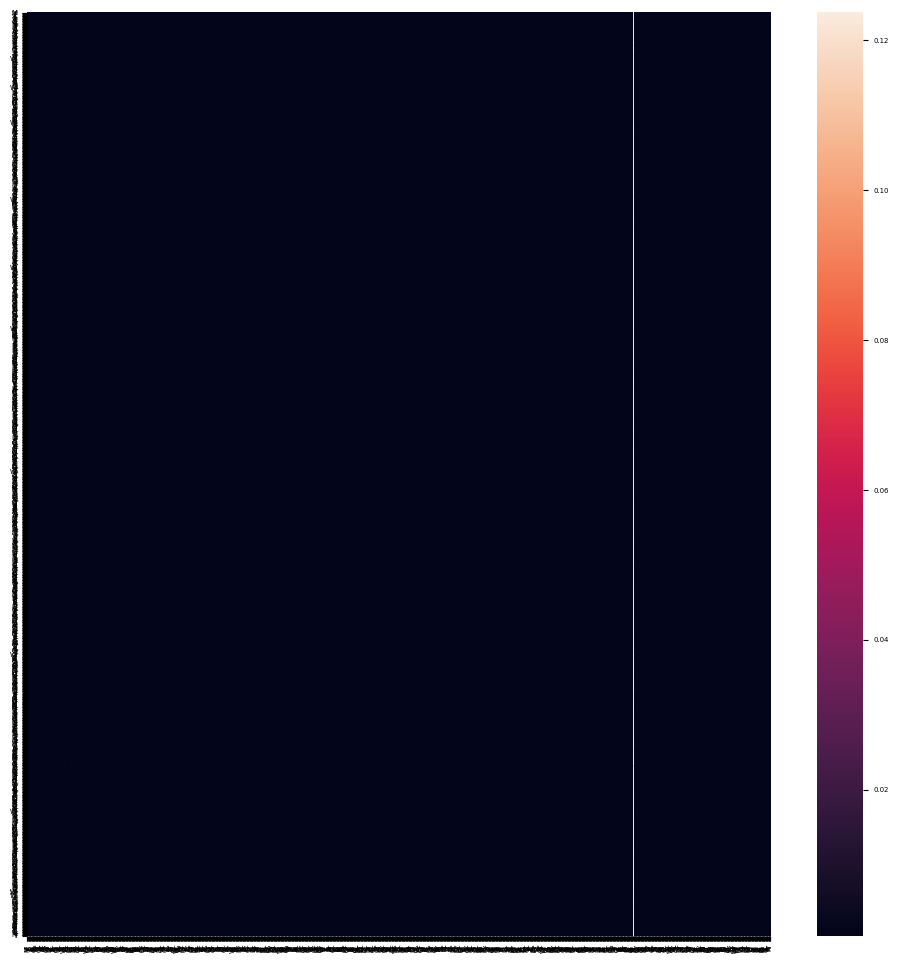

Top 10 tokens + positions with highest attention values for the whole sequence
     tokens  attn_vals   pos
1038      R   0.121021  1038
1037      K   0.003943  1037
764       R   0.001543   764
1018      R   0.001221  1018
76        K   0.001192    76
457       K   0.001172   457
96        K   0.001167    96
112       K   0.001161   112
528       K   0.001130   528
181       K   0.001117   181


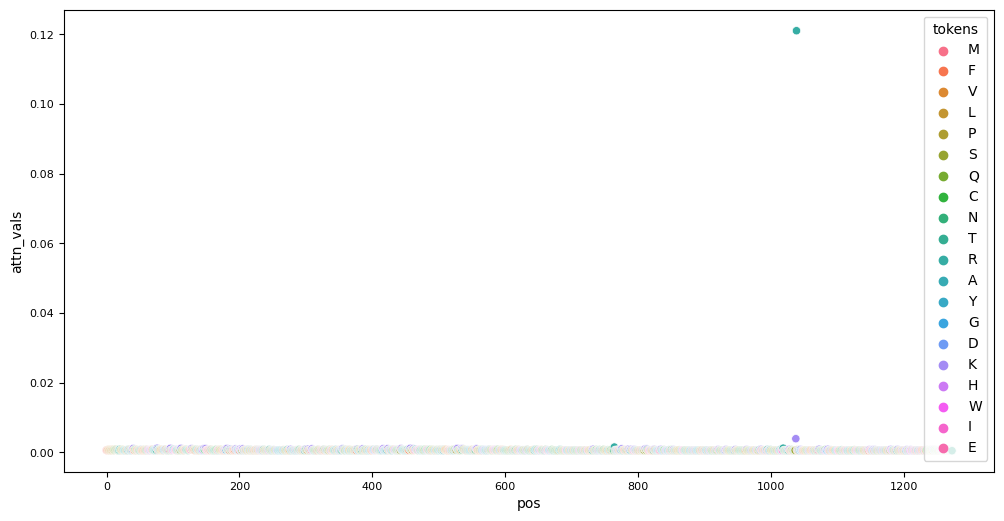

In [17]:
analyze_attention_of_sequence(pre_trained_transformer_encoder_model, wiv04_seq, wiv04_label, test_sequence_settings["max_sequence_length"])

##### Fine Tuned Host Prediction Model: UniRef90

torch.Size([1, 1366])
seq_len = 1273
Label = Human
Prediction = Human


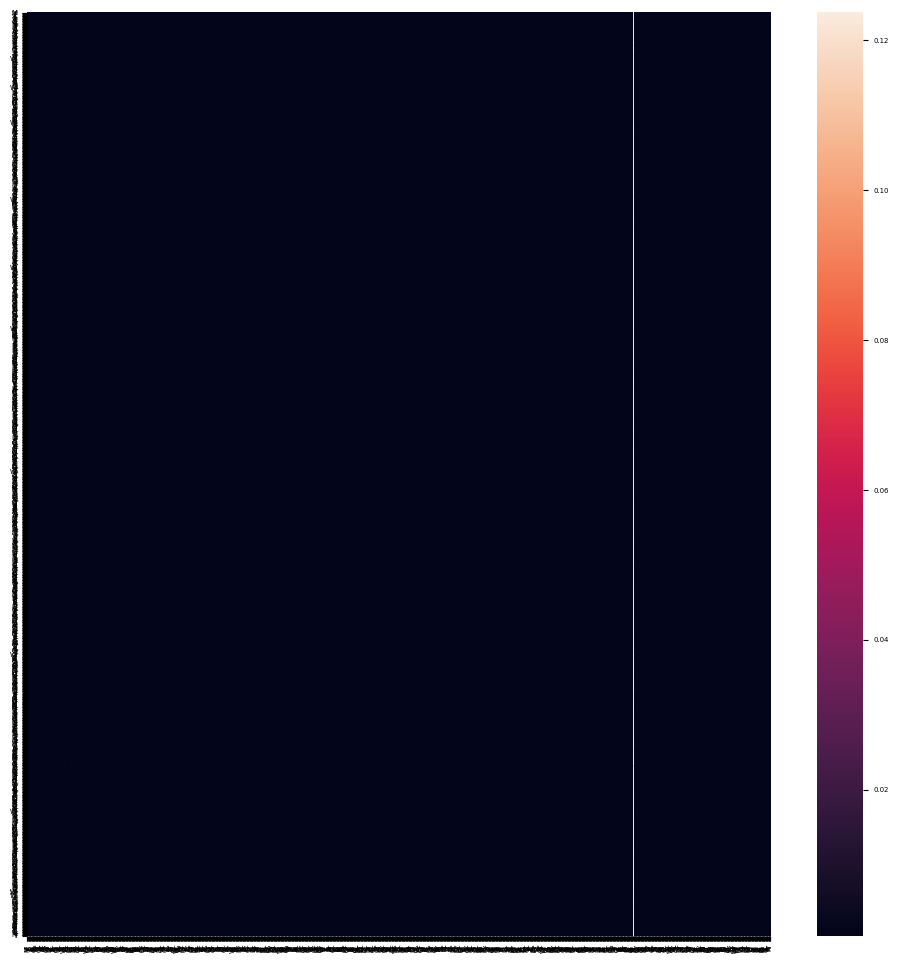

Top 10 tokens + positions with highest attention values for the whole sequence
     tokens  attn_vals   pos
1038      R   0.121021  1038
1037      K   0.003943  1037
764       R   0.001543   764
1018      R   0.001221  1018
76        K   0.001192    76
457       K   0.001172   457
96        K   0.001167    96
112       K   0.001161   112
528       K   0.001130   528
181       K   0.001117   181


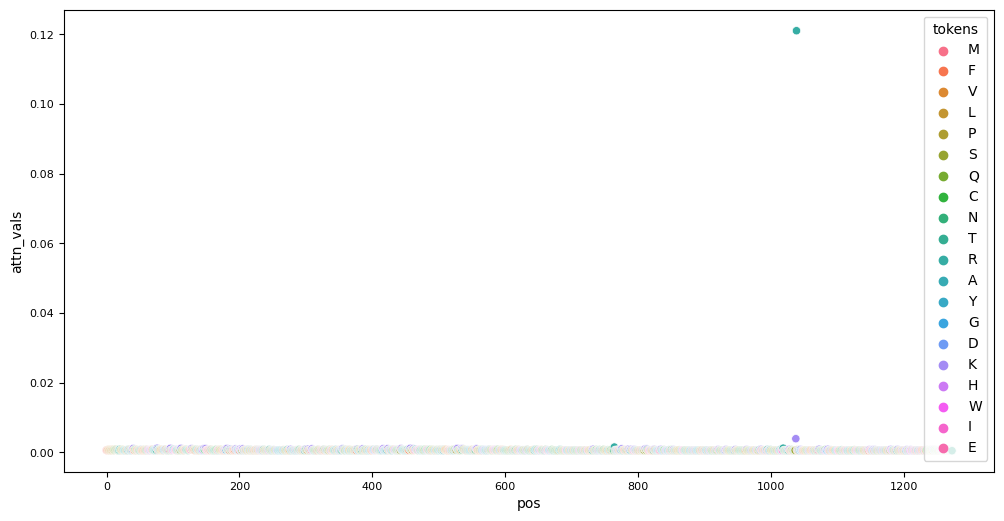

In [15]:
analyze_attention_of_prediction(fine_tuned_host_prediction_model_uniref90, wiv04_seq, wiv04_label, test_sequence_settings["max_sequence_length"])

##### Fine Tuned Host Prediction Model: Coronaviridae

torch.Size([1, 1366])
seq_len = 1273
Label = Human
Prediction = Goat


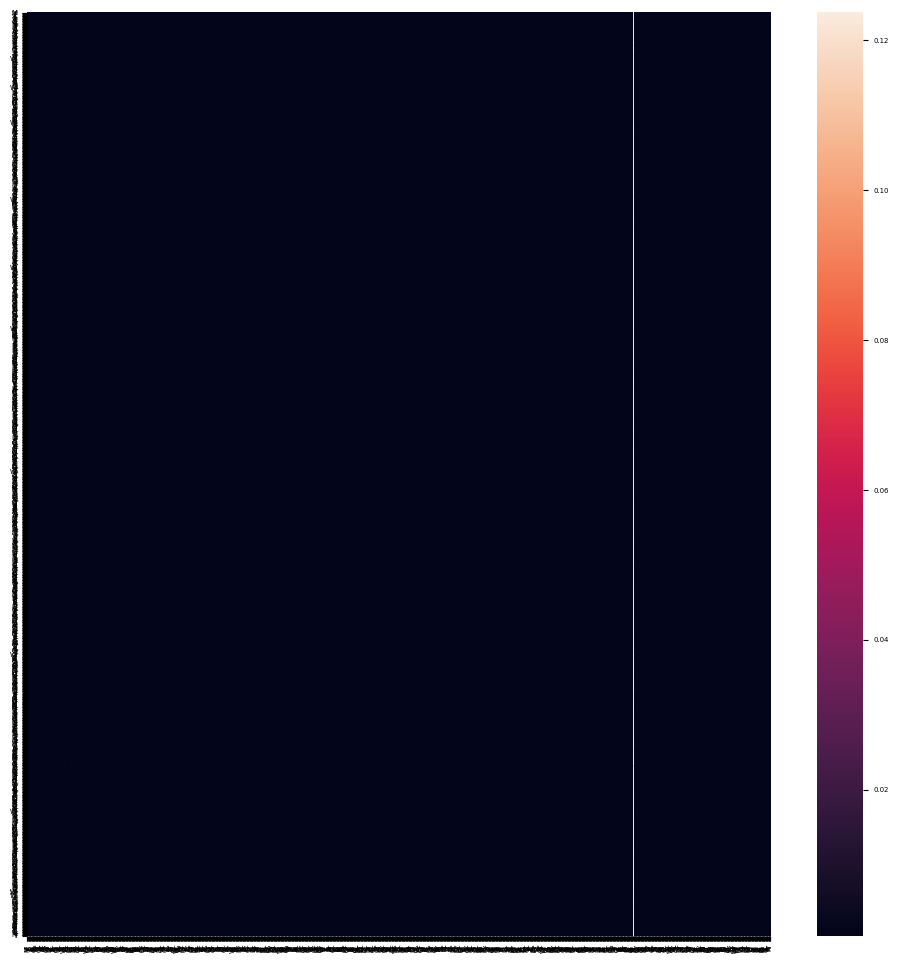

Top 10 tokens + positions with highest attention values for the whole sequence
     tokens  attn_vals   pos
1038      R   0.121021  1038
1037      K   0.003943  1037
764       R   0.001543   764
1018      R   0.001221  1018
76        K   0.001192    76
457       K   0.001172   457
96        K   0.001167    96
112       K   0.001161   112
528       K   0.001130   528
181       K   0.001117   181


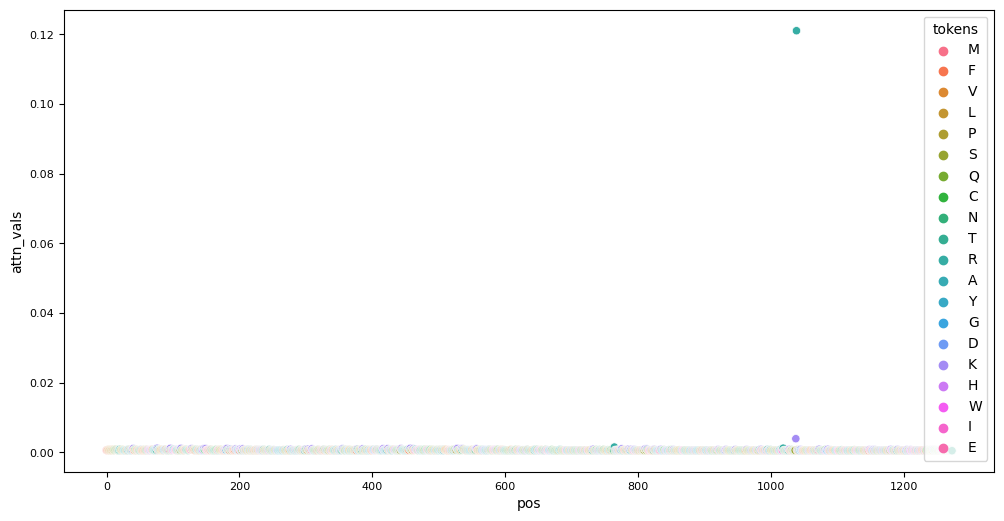

In [16]:
analyze_attention_of_prediction(fine_tuned_host_prediction_model_coronaviridae, wiv04_seq, wiv04_label, test_sequence_settings["max_sequence_length"])